# Why embed networks?

Networks by themselves can have interesting properties, but a network is not how you traditionally organize data in computer science. In almost any ML algorithm - whether you're using a neural network or a decision tree, whether your goal is to classify observations or to predict values using regression - you'll see data organized into a matrix, where the rows represent observations and the columns represent features, or variables. Each observation, or row of the matrix, is traditionally represented as a single point in $d$-dimensional space (if there are $d$ columns in the matrix). If you have two columns, for instance, you could represent data organized in this way on an x/y coordinate plane. The first column would represent the x-axis, and the second column would represent the y-axis.

For example, the data below is organized traditionally. On the left is the data matrix; each observation has its own row, with two features across the columns. The first column contains the first feature for each observation, and the second column contains the second feature for each observation. You can see the two clusters of data numerically, through the color mapping.

On the right is the same data, but plotted in Euclidean space. Each column of the data matrix gets its own axis in the plot. The x and y axis location of the $i^{th}$ point in the scatterplot is the same as the first and second feature values of the $i^{th}$ row of the data matrix. You can see the two clusters of data geometrically, through the location of the observations as points in the scatter plot.

In [1]:
from sklearn.datasets import make_blobs
import numpy as np

# make the data
centers = np.array([[-2, -2], 
                    [2, 2]])
X, labels = make_blobs(n_samples=10, cluster_std=0.5,
                  centers=centers, shuffle=False)


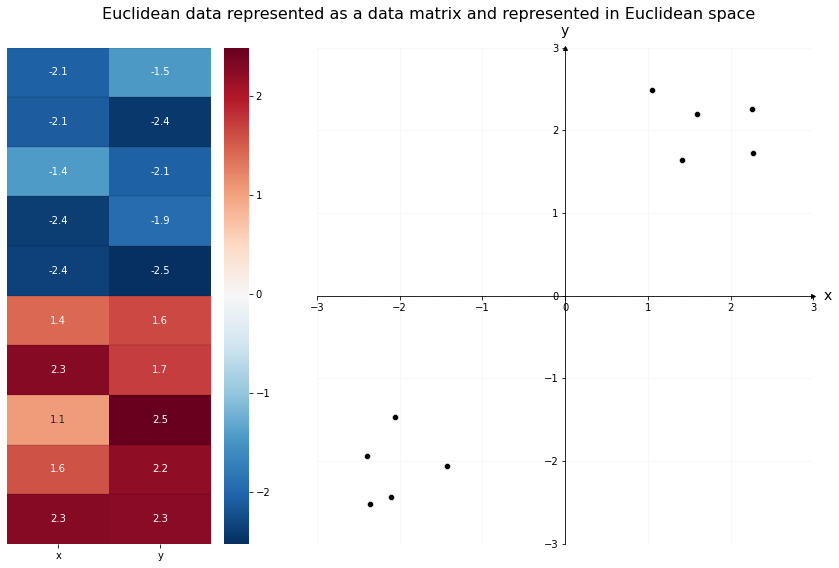

In [2]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import seaborn as sns
from graphbook_code import GraphColormap, draw_cartesian

# convert data into a DataFrame
data = pd.DataFrame(X, columns=["x", "y"])
# setup
cmap = GraphColormap("divergent", k=2).color
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(1, 3)
axm = fig.add_subplot(gs[0])
axs = fig.add_subplot(gs[1:])

# plot left
hm = sns.heatmap(data, ax=axm, yticklabels=False, 
                 cmap=cmap, annot=True, cbar=True)
hm.hlines(range(len(data)), *hm.get_xlim(), colors='k', alpha=.1)

# plot right
draw_cartesian(ax=axs)
plot = sns.scatterplot(data=data, x='x', y='y', legend=False, ax=axs, color="k")

# lines
max_ = int(data.values.max()) + 1
plot.vlines(0, -max_, max_, colors="black", lw=.9, linestyle="dashed", alpha=.2)
plot.hlines(0, -max_, max_, colors="black", lw=.9, linestyle="dashed", alpha=.2)

# ticks
plot.xaxis.set_major_locator(plt.MaxNLocator(6))
plot.yaxis.set_major_locator(plt.MaxNLocator(6))

# set axis bounds
lim = (-max_, max_)
plot.set(xlim=lim, ylim=lim)

# title, etc
plt.suptitle("Euclidean data represented as a data matrix and represented in Euclidean space", fontsize=16)
plt.tight_layout()

It's often useful for our data to be organized like this, since it opens the door to a wide variety of machine learning methods. With the data above, for example, you could use scikit-learn to perform simple K-Means Clustering to find the two clusters of observations. Below, you import scikit-learn's K-Means clustering algorithm. K-Means finds a pre-determined number of clusters in your data by setting randomly determined starting-points, and then iterating to get these points closer to the true cluster means. It outputs the community membership labels for each observation, which you can see below.

In [3]:
from sklearn.cluster import KMeans

predicted_labels = KMeans(n_clusters=2).fit_predict(X)
print("Predicted labels: ", predicted_labels)

Predicted labels:  [1 1 1 1 1 0 0 0 0 0]


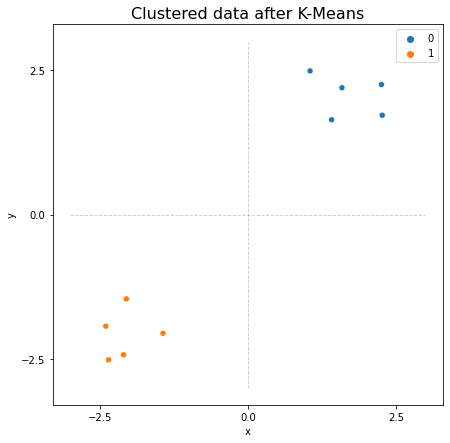

In [4]:
fig, ax = plt.subplots(figsize=(7, 7))
from graphbook_code import cmaps

# plot right
plot = sns.scatterplot(data=data, x='x', y='y', ax=ax, 
                       hue=predicted_labels, palette=cmaps["qualitative"])

# lines
plot.vlines(0, -max_, max_, colors="black", lw=.9, linestyle="dashed", alpha=.2)
plot.hlines(0, -max_, max_, colors="black", lw=.9, linestyle="dashed", alpha=.2)

# ticks
plot.xaxis.set_major_locator(plt.MaxNLocator(3))
plot.yaxis.set_major_locator(plt.MaxNLocator(3))

# title
plot.set_title("Clustered data after K-Means", fontsize=16);

Network-valued data are different. Take the sample from a Stochastic Block Model below, shown as both a layout plot and an adjacency matrix. Say your goal is to view the nodes as particular observations, and you'd like to cluster the data in the same way you clustered the Euclidean data above. Intuitively, you'd expect to find two groups: one for the first set of heavily connected nodes, and one for the second set. Unfortunately, traditional machine learning algorithms won't work on data represented as a network: it doesn't live in the traditional rows-as-observations, columns-as-features format.

In [5]:
import networkx as nx
from graspologic.simulations import sbm
np.random.seed(1)

p = np.array([[.9, .1],
              [.1, .9]])
A, labels = sbm([25, 25], p, return_labels=True)

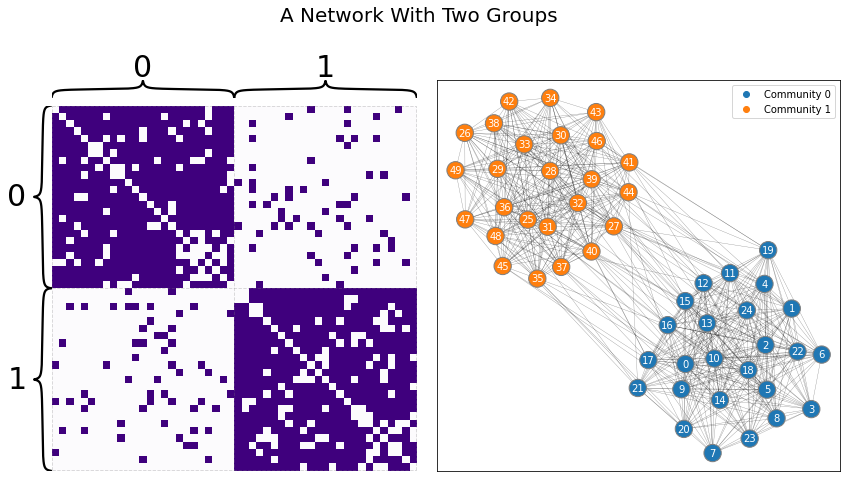

In [6]:
from graphbook_code import draw_multiplot
axs = draw_multiplot(A, labels=labels, title="A Network With Two Groups")

You, of course, *can* make up methods which work directly on networks - algorithms which run by traversing along edges, for instance, or which use network statistics like node degree to learn, and so on - and data scientists have developed many algorithms like this. But to be able to use the entire toolbox that machine learning offers, you'd like to be able to figure out a way to *represent* networks in Euclidean space as tabular data. This is why having good embedding methods, like spectral embeddings or graph neural networks (which we'll learn about soon), is useful. There's another problem with networks that make embedding into lower-dimensional space useful.

## High dimensionality of network data

The other problem with network data is its high dimensionality. You could view each element of an adjacency matrix as its own (binary, for unweighted networks) dimension, for instance -- although you could also make the argument that talking about dimensionality doesn't even make *sense* with network data, since it doesn't live in Euclidean space. Regardless, if you were to view the elements of the adjacency matrix as their own dimensions, you can get to a fairly unmanageable number of dimensions fairly quickly -- in fact, for a simple network, the number of dimensions is $\binom n 2$, as you learned back in [Chapter 4](ch4:prop:net-dens). Many dimensions can generally be unmanageable largely because of a machine learning concept called the *curse of dimensionality*, described in [Elements of Statistical Learning](#https://www.amazon.com/Elements-Statistical-Learning-Prediction-Statistics/dp/0387848576/ref=asc_df_0387848576/?tag=hyprod-20&linkCode=df0&hvadid=312140868236&hvpos=&hvnetw=g&hvrand=7340427778028014499&hvpone=&hvptwo=&hvqmt=&hvdev=c&hvdvcmdl=&hvlocint=&hvlocphy=9007909&hvtargid=pla-487139763557&psc=1).

### The dimensions are intrinsically linked

If you are familiar with linear regression, you can understand another major problem when dealing with network data. Not only are there a *lot* of dimensions to network data, but these dimensions are *intrinsically linked* to one another. 

Let's start you off by first doing a quick recap of a linear regression problem. Let's say that you have $2560$ lobsters, and you know that these lobsters are a mix of male and female lobsters. Lobsters are *indeterminate growers*, which means that they just keep growing as they get older and older. Of these lobsters, you know whether they are male or female, and you also know the total length of the lobster. As it turns out, male lobsters have *substantially* larger claws than female lobsters. You want to learn whether, given whether a lobster is male or female and its length, can you predict its claw size? Let's start by importing in the dataset we will be using. You can find the data from Tonje Knutsen Sørdalen over [here](https://datadryad.org/stash/dataset/doi:10.5061/dryad.m37pvmczq) if you want to have more information about how it was collected. You can download the data locally using python with the following commands. Let's get to it:

In [7]:
import pandas as pd
import os
import urllib

BOOK_ROOT = "https://raw.githubusercontent.com/neurodata/graph-stats-book/"
LOBST_DEST = "datasets"
LOBST_URL = BOOK_ROOT + "master/network_machine_learning_in_python/representations/ch6/datasets"
LOBST_NAME = "lobster.tsv"

def fetch_lobster_data(lobst_url=LOBST_URL, lobst_dest=LOBST_DEST,
                       lobst_name=LOBST_NAME):
    if not os.path.isdir(lobst_dest):
        os.makedirs(lobst_dest)
    lobst_file = os.path.join(lobst_dest, lobst_name)
    if not os.path.exists(lobst_file):
        lobst_tsv_url = os.path.join(lobst_url, lobst_name)
        urllib.request.urlretrieve(lobst_tsv_url, lobst_file)
    return pd.read_csv(lobst_file, sep="\t", encoding="latin-1")

lobst_dat = fetch_lobster_data()

Because lobsters tend to grow over their entire bodies, the size will tend to be associated with the claw size. Also, because male lobsters have bigger claws than female lobsters, the biological sex of the lobster will be a big factor on the size of the claw. Let's take a look at how these relationships exist in our data, by looking at the size of the claw as a function of the size of the lobster, separated by biological sex:

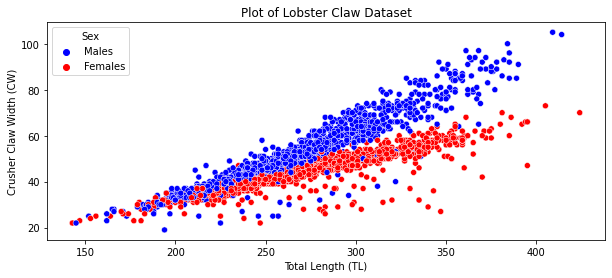

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(10, 4))
palette = {"Males": "blue", "Females": "red"}
sns.scatterplot(data=lobst_dat, x="TotalLength", y="CrusherClawWidth", hue="Sex",
               palette=palette, ax=ax)
ax.set_xlabel("Total Length (TL)")
ax.set_ylabel("Crusher Claw Width (CW)")
ax.set_title("Plot of Lobster Claw Dataset");

As you can see, it looks like larger lobsters tend to have larger claws, and male lobsters tend to have larger claws. As you can also see, the points do not really lie parallel: if a lobster is male, its claw increases at a *higher rate* with length than if a lobster is female.

You come up with a model that the lobster size and biological sex operate as predictors for the claw size. You do this by just saying that claw size is a function of biological sex and length. Let's do this with `statsmodels` OLS (ordinary least squares linear regression) function. We'll take a look at the estimates of the parameters for how sex and length predict claw size:

In [9]:
import statsmodels.formula.api as smf

# regression of claw width onto length and sex of lobster
model = smf.ols('CrusherClawWidth ~ TotalLength + Sex', data=lobst_dat)
model = model.fit()
print(model.params)

Intercept      -20.438015
Sex[T.Males]     9.508218
TotalLength      0.237113
dtype: float64


The interpretation of the parameter for sex is that, if a lobster is a male, its claw tends to be $9.51$ units larger than if the lobster was female, at a given length. The interpretation of the parameter for total length is that, with biological sex fixed, a single unit increase in the total length tends to increase its claw width by $.24$ units. We can look at our prediction quality as well, by looking at the two lines we fit:

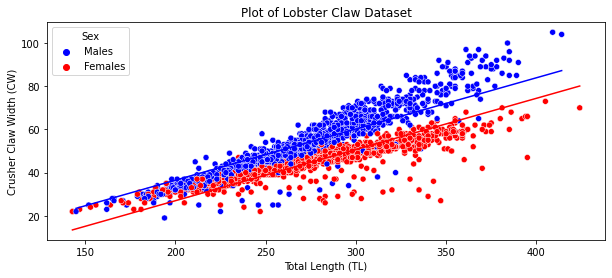

In [10]:
lobst_dat["Predictions"] = model.predict()
sns.lineplot(data=lobst_dat, x="TotalLength", y="Predictions", hue="Sex",
            palette=palette, ax=ax, legend=False)
fig

When you force this through the crank of linear regression like this, you are shortchanging yourself. As you can see from the scatter plot, these lines are *totally* parallel, which doesn't reflect the fact that the male lobster length/claw width relationship is steeper than for females. If we were to adjust the regression to allow for this *interaction* of length and biological sex, we would get a much better model:

In [11]:
import statsmodels.formula.api as smf

# add interaction term between total length and sex
model_interact = smf.ols('CrusherClawWidth ~ TotalLength + Sex + TotalLength:Sex', data=lobst_dat)
model_interact = model_interact.fit()

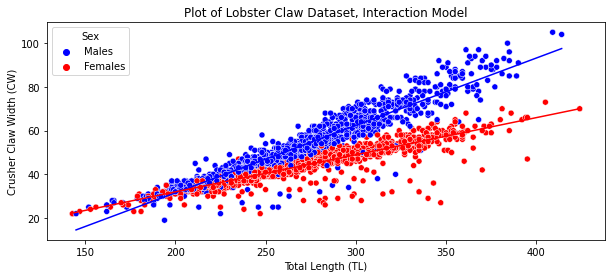

In [17]:
lobst_dat["Predictions (Interaction)"] = model_interact.predict()
sns.lineplot(data=lobst_dat, x="TotalLength", y="Predictions", hue="Sex",
            palette=palette, ax=ax, legend=False)

fig, ax = plt.subplots(1,1, figsize=(10, 4))
palette = {"Males": "blue", "Females": "red"}
sns.scatterplot(data=lobst_dat, x="TotalLength", y="CrusherClawWidth", hue="Sex",
               palette=palette, ax=ax)
ax.set_xlabel("Total Length (TL)")
ax.set_ylabel("Crusher Claw Width (CW)")
ax.set_title("Plot of Lobster Claw Dataset, Interaction Model")

sns.lineplot(data=lobst_dat, x="TotalLength", y="Predictions (Interaction)", hue="Sex",
            palette=palette, ax=ax, legend=False);

The lines are no longer parallel, and as you can see, we are able to do a much better job of capturing that male lobster claw width increases with total length at a faster rate than for females. In this sense, there is a dependence of crusher claw width on the total length of the lobster, its biological sex, and the relationship between the total length and the biological sex.

All the same, networks have this sort of interaction, too, but on a much wider scale. This is both a *logical* and *statistical dependence*, which (without getting too technical), means that edges are related to one another. Let's imagine you have a social network of $100$ students. Here, the nodes are the students, and the edges are whether or not a pair of students are friends. If you knew that the school president was extremely popular, then all of the edges in the network that are associated with the school president are also *interacting*, in that if you knew that an edge had a node which represented the school president, it would be *much* more likely to exist (since the school president has many friends). While this would be an extreme example, as you can see, these sorts of *dependences* can permeate through the entire network. If Alice is friends with Bob and Bob is friends with Desean, it might make sense to think that Alice might be more likely to be friends with Desean too. This would be another type of edge interaction. This pattern just builds and builds in network data. Since there are an enormous number of edges to start with, and a similarly enormous number of interactions between edges and all of the other edges they tend to be associated with, successfully capturing the system underlying the network becomes a real headache.

## How do you embed network data?

This is where network embedding methods come into play. Because networks represented as adjacency matrices are extremely high-dimensional, they run into many of the issues described above. Embedding, much like traditional dimensionality reduction methods in machine learning like Principle Component Analysis (PCA), allows us to move down to a more manageable number of dimensions while still preserving useful information about the network.

Embedding is, first and foremost, a tool. As you read previously, you can rarely perform analyses on network data in its rawest form. Embedding is the "bridge" which provides functionality you need (namely, making the data *smaller*, and *simpler*) so that you can churn it through the machine learning algorithms you are familiar with from elsewhere on your network data. You can embed your network, and doing *nothing else*, answer questions you might have about it. There is, however, another role that embedding has. If you make some assumptions about the network, you can also use embeddings to *learn* valuable representations of your data that will allow you to answer more formal questions than you could using simple, out-of-the-box machine learning algorithms. Using embeddings coupled with statistical models, you can *estimate* parameters for the statistical models you learned about in [Chapter 5](ch5), and then use statistical properties about these parameters to perform *model-based* inference.

### You often embed to estimate latent positions

The embedding methods which we'll explore the most in this book are the spectral methods. These methods pull heavily from linear algebra to keep the information about our network which is useful for learning about statistical network models - and use that information to place nodes in Euclidean space. We'll explore other methods as well. It's worth it to know a bit of linear algebra review here, particularly on concepts like eigenvectors and eigenvalues, as well as the properties of symmetric matrices. We'll guide you as clearly as possible through the math in future sections.

Spectral embedding methods and graph neural networks in particular, which we'll talk about in later sections, will estimate an embedding called the latent position matrix. This is an $n \times d$ matrix (where this are $n$ rows, one for each node, and $d$ dimensions for each row). The latent position matrix is thus organized like a traditional data table, with nodes corresponding to observations, and you could plot the rows as points in Euclidean space. You'll have a gentle introduction here before we dive into the weeds in the next few sections.

### What the heck is the latent position matrix, anyway?

What actually is a latent position? How can you interpret a latent position matrix?

To recap from {ref}`ch5:rdpg`, assuming you believe your network might be some type of random dot product graph (remember that this can include SBMs, ER networks, and more), you can think of every node as being secretly associated with a position in Euclidean space. This position (relative to the positions associated with other nodes) tells you the probability that one node will have an edge with another node.

Remember that $X$ has $n$ rows (the number of nodes) and $d$ columns (the number of dimensions). Although in practice you almost never know what the latent position matrix *actually* is, you can *estimate it* by embedding your network.

You're going to cheat a bit and use an embedding method (in this case, adjacency spectral embedding) before we've discussed it, just to show what this looks like. In the next section, you'll learn how this embedding is happening, but for now, just think of it as a way to estimate the latent positions for the nodes of a network and move from network space to Euclidean space.

Below you make a network, which in this case is an SBM. From the network, you can estimate a set of latent positions, where $n=20$ rows for each node and $d=2$ dimensions. Usually when something is an estimation for something else in statistics, you put a hat over it: $\hat{X}$. We'll do that here.

In [18]:
from graspologic.simulations import sbm
from graspologic.embed import AdjacencySpectralEmbed as ASE
import numpy as np

# make a network
B = np.array([[0.8, 0.1], 
              [0.1, 0.8]])
n = [10, 10]
A, labels = sbm(n=n, p=B, return_labels=True)

# embed
ase = ASE(n_components=2)
X = ase.fit_transform(A)

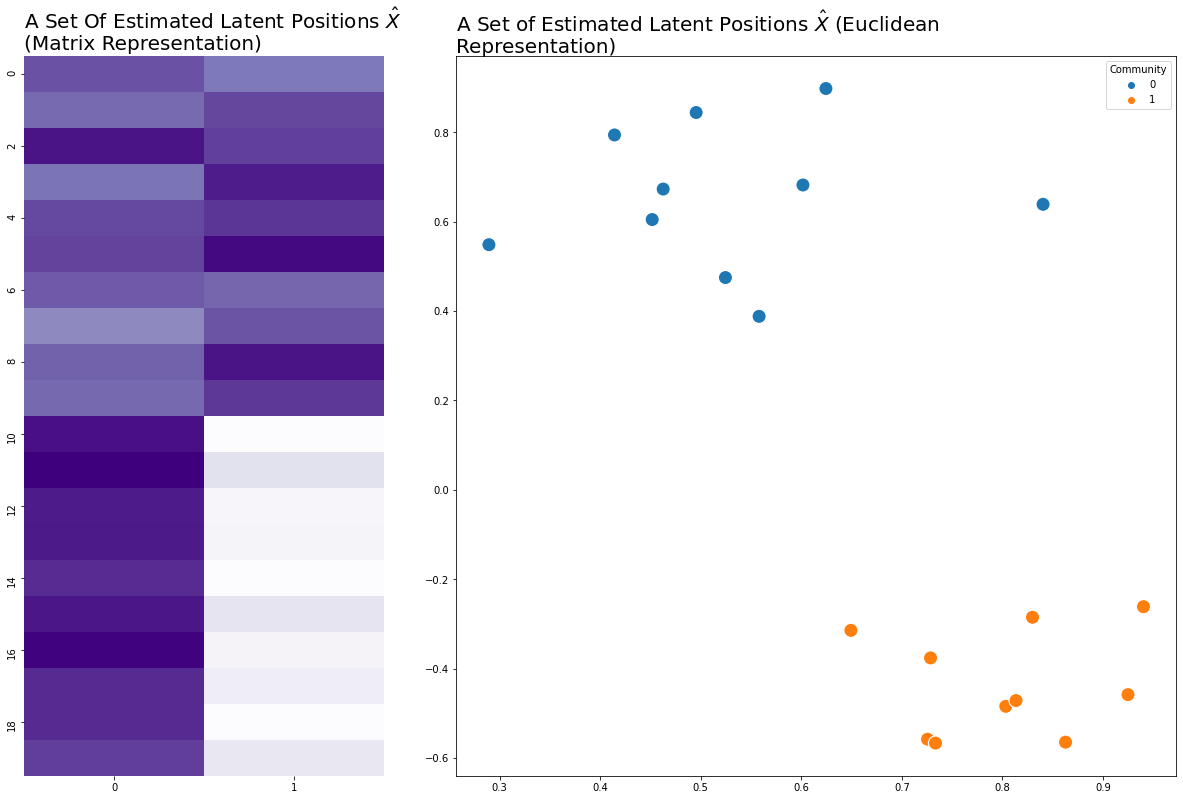

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from graphbook_code import cmaps, plot_latents

fig = plt.figure(figsize=(5, 10))
ax = fig.add_axes([0, 0, 1, 1])
cmap = cmaps["sequential"]
ax = sns.heatmap(X, cmap=cmap, cbar=False, xticklabels=1, yticklabels=2, ax=ax)
ax.set_title("A Set Of Estimated Latent Positions $\hat{X}$ \n(Matrix Representation)", 
             loc='left', fontdict={"fontsize": 20});

ax_eucl = fig.add_axes([1.2, 0, 2, 1])
plot_latents(X, labels=labels, title="A Set of Estimated Latent Positions $\hat{X}$ (Euclidean Representation)", 
             fontdict={"fontsize": 20}, s=200);

It's good to emphasize here that we're modeling our networks as *random dot-product graphs* (RDPGs). One implication is that you can think of a network as having some underlying probability distribution, and any specific network is one of many possible realizations of that distribution. It also means that each edge in our network has some *probability* of existing: nodes 0 and 3, for instance, may or may not have an edge. The concept of a latent position only makes sense under the assumption that the network is drawn from an RDPG.

We're going to state this again just to emphasize the importance of the last sentence. You most certainly *can* embed a network without assuming the network is an RDPG. However, the resulting embedding derives an interpretation, which goes *beyond* the scope of simply being a set of points in $d$ dimensions, when you make an assumption that the network is a RDPG. We will cover this particularity more in depth over the next few sections. 

#### Estimating a probability matrix from the estimated patent positions

Similarly, you can find an estimate of the probability matrix $\hat P$ for your network using the latent positions. How would you generate $\hat P$ from $\hat X$?

Well, you'd just multiply it by its transpose: $\hat P = \hat X\hat X^\top$. This operation will take the dot product between every row of $X$ and put it in the result. $(\hat X\hat X^\top)_{ij}$ will just be the dot product between rows $i$ and $j$ of the estimated latent position matrix (which is the estimated probability that nodes $i$ and $j$ will be connected). So, $\hat X\hat X^\top$ is just the $n \times n$ estimated probability matrix - if you've estimated your latent positions using samples of networks, you can also estimate the probability matrix.

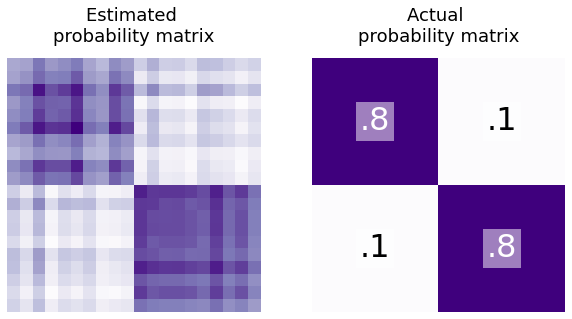

In [25]:
from graphbook_code import text


shape = (X.shape[0]//2, X.shape[0]//2)
B0 = np.full(shape, .8)
B1 = np.full(shape, .1)

# block probability matrix
B = np.block([[B0, B1],
              [B1, B0]])



from graphbook_code import heatmap

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

heatmap(X@X.T, title="Estimated \nprobability matrix", ax=axs[0], cbar=False);
heatmap(B, title="Actual \nprobability matrix", ax=axs[1], cbar=False)

# text
text(".8", .25, .75, color="white")
text(".8", .75, .25, color="white")
text(".1", .25, .25)
text(".1", .75, .75);

#### Thinking About latent positions geometrically

You can also think about this stuff geometrically. The dot product between any two vectors $\vec x_i$ and $\vec x_j$, geometrically, is their lengths multiplied together and then weighted by the cosine of the angle between them. Smaller angles have cosines close to 1, and larger angles have cosines close to 0. So, nodes whose latent positions have larger angles between them tend to have lower edge probabilities, and nodes whose latent positions have smaller angles between them tend to have higher edge probabilities. This is the core intuition you need to understand as to why you can find communities and do downstream inference with latent position matrices: two nodes whose latent positions are further apart will have a smaller probability of having an edge between them! This particular topic, called [Community Detection](ch7:comm_detect), will arise later in the applications section of the book.

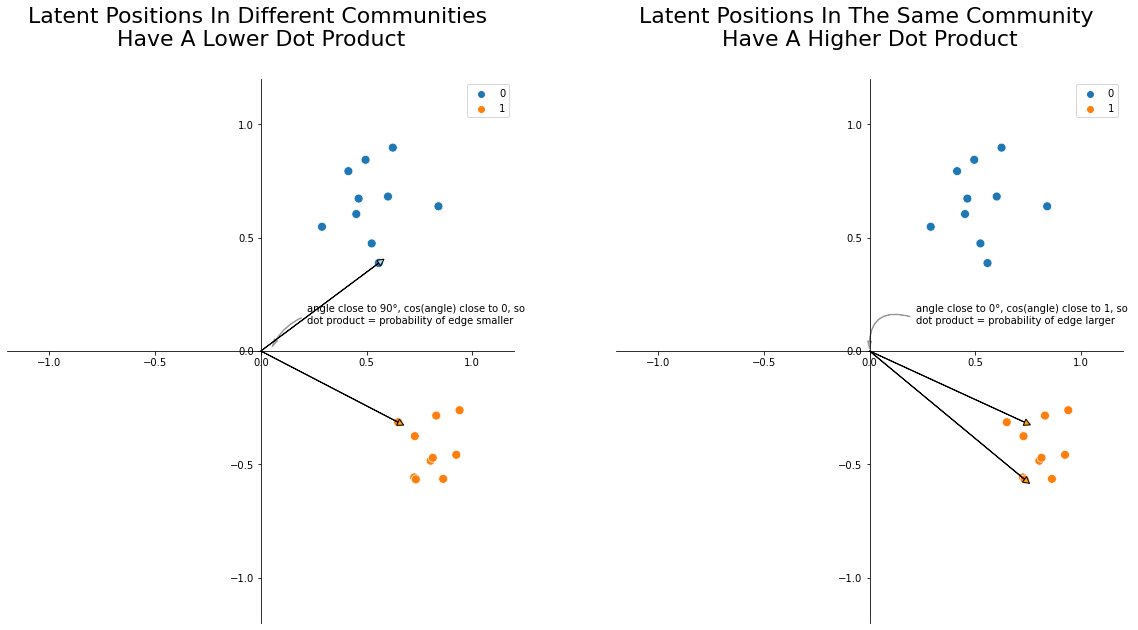

In [21]:
import matplotlib.patches as patches

fig, axs = plt.subplots(1, 2, figsize=(20, 10))


####### First Ax
# background plot
ax = axs[0]
plot = sns.scatterplot(
    x=X[:, 0],
    y=X[:, 1],
    hue=labels,
    s=80,
    ax=ax,
    palette="tab10",
    color="k",
)
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-1.2, 1.2])

# plot vector arrows
u_i = X[0]
u_j = X[-1]
ax.arrow(0, 0, u_i[0], u_i[1], head_width=0.03, head_length=0.03, fc='lightblue', ec='black')
ax.arrow(0, 0, u_j[0], u_j[1], head_width=0.03, head_length=0.03, fc='orange', ec='black')

# Text and text arrow
style = "Simple, tail_width=0.5, head_width=4, head_length=8"
kw = dict(arrowstyle=style, color="k", alpha=.3)
text_arrow = patches.FancyArrowPatch((0.2, 0.15), (.05, .01), connectionstyle="arc3, rad=.2", **kw)
txt = r"""
angle close to 90°, cos(angle) close to 0, so 
dot product = probability of edge smaller
"""
ax.text(0.22, 0.07, txt)
ax.add_patch(text_arrow)

ax.set_title("Latent Positions In Different Communities \nHave A Lower Dot Product", y=1.05, fontsize=22);

####### Second Ax
ax = axs[1]
plot = sns.scatterplot(
    x=X[:, 0],
    y=X[:, 1],
    hue=labels,
    s=80,
    ax=ax,
    palette="tab10",
    color="k",
)
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-1.2, 1.2])

# plot vector arrows
u_i = X[-1]
u_j = X[-2]
ax.arrow(0, 0, u_j[0], u_i[1], head_width=0.03, head_length=0.03, fc='orange', ec='black')
ax.arrow(0, 0, u_j[0], u_j[1], head_width=0.03, head_length=0.03, fc='orange', ec='black')

# Text and text arrow
style = "Simple, tail_width=0.5, head_width=4, head_length=8"
kw = dict(arrowstyle=style, color="k", alpha=.3)
text_arrow = patches.FancyArrowPatch((0.2, .15), (0, 0), connectionstyle="arc3, rad=.7", **kw)
txt = r"""
angle close to 0°, cos(angle) close to 1, so 
dot product = probability of edge larger
"""
ax.text(0.22, 0.07, txt)
ax.add_patch(text_arrow)

ax.set_title("Latent Positions In The Same Community \nHave A Higher Dot Product", y=1.05, fontsize=22);

If you have an *estimate* for the latent positions, there's math that shows that you get a pretty good estimate for the probability matrix as well. In practice, that's what you're actually doing: getting an estimate of the latent positions with spectral embedding, then using those to do more downstream tasks or estimating probability matrices.